In [1]:
from __future__ import absolute_import, division, print_function
import re
import json
import pandas as pd  
import numpy as np
import string, os 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import unicodedata
import time
import tensorflow as tf
import pickle

tf.enable_eager_execution()
print('Tensorflow version', tf.__version__)

%env CUDA_VISIBLE_DEVICES=0,1
%env CUDA_VISIBLE_DEVICES

Tensorflow version 1.14.0
env: CUDA_VISIBLE_DEVICES=0,1


'0,1'

In [2]:
#load the saved df with gold training data having concatenated reviews
with open('../data/dataframe_nearest_1day.pkl', 'rb') as f:
    data = pickle.load(f)

In [3]:
data.axes

[RangeIndex(start=0, stop=54676, step=1),
 Index(['index', 'business_id', 'user_id', 'compliment_count', 'date', 'text_x',
        'cool', 'funny', 'review_id', 'stars', 'text_y', 'useful'],
       dtype='object')]

In [4]:
#Prep data according to the input format
#Replace new line (\n) with the user-defined token
path_to_data = '../data/reviews_and_tips_nearest_1day.txt'
data = data.drop(['index', 'cool', 'date', 'cool', 'funny', 'review_id', 'stars', 'useful', 'compliment_count', 'business_id', 'user_id'], axis = 1)
data.text_x = data.text_x.apply(lambda x: x.replace('\n', '<newline>'))
data.text_y = data.text_y.apply(lambda x: x.replace('\n', '<newline>'))
data.to_csv(path_to_data, header=None, index=None, sep='\t', line_terminator = '\line')

In [5]:
def remove_empty_lines(filename):
    """Overwrite the file, removing empty lines and lines that contain only whitespace."""
    with open(filename) as in_file, open(filename, 'r+') as out_file:
        out_file.writelines(line for line in in_file if line.strip())
        out_file.truncate()

# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   #NFD = canonical decomposition; translates each character into its decomposed form
        if unicodedata.category(c) != 'Mn')
  #Mn = mark, nonspacing


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
        
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
        
    w = re.sub(r'[" "]+', " ", w)
        
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
        
    w = w.rstrip().strip()
        
    w = '<start> ' + w + ' <end>'
    
    return w

In [6]:
class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        #create set

        #?^

        self.create_index()

    def create_index(self):
        for phrase in self.lang:
          #print(type(phrase))
          self.vocab.update(phrase.split(' '))

        self.vocab = sorted(self.vocab)

        self.word2idx['<pad>'] = 0
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1

        for word, index in self.word2idx.items():
            self.idx2word[index] = word

In [7]:
def create_dataset(path):
    lines = open(path, encoding='UTF-8', newline = '').read().strip().split('\line')
    

    res = pd.DataFrame(lines)
    #print(len(lines))
    #print(res.shape)
    
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines]
    #\t = TAB 
    
    return word_pairs            
            
#Validate
def max_length(tensor):
    return max(len(t) for t in tensor)

def load_dataset(path):
    
    pairs = create_dataset(path)   
    pairs.pop()
    
    inp_lang = LanguageIndex(review for tip, review in pairs)
    
    targ_lang = LanguageIndex(tip for tip, review in pairs)
    
    input_tensor = [[inp_lang.word2idx[s] for s in review.split(' ')] for tip, review in pairs]
    
    target_tensor = [[targ_lang.word2idx[s] for s in tip.split(' ')] for tip, review in pairs]
    
    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)
    
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=max_length_inp,
                                                                 padding='post')
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=max_length_tar, 
                                                                  padding='post')
    return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

In [8]:
# Try experimenting with the size of that dataset
input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = load_dataset(path_to_data)
print('Input tensor shape: ', input_tensor.shape)
print('Target tensor shape: ', target_tensor.shape)

Input tensor shape:  (54676, 285)
Target tensor shape:  (54676, 77)


In [9]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(43740, 43740, 10936, 10936)

In [10]:
%config IPCompleter.greedy=True

In [11]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE//BATCH_SIZE
#embedding_dim = 256
#embedding_dim = 128
embedding_dim = 100
#embedding_dim = 2
units = 16
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [12]:
tf.test.is_gpu_available()

True

In [13]:
def gru(units):
  # If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
  # the code automatically does that.
  if tf.test.is_gpu_available():
    return tf.keras.layers.CuDNNGRU(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
  #glorot uniform draws samples from a uniform distribution within [-limit, limit] 
  else:
    return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')

In [14]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))
      #tf.zeros creats tensors with all elements set to 0

In [15]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        #turns positive integers (indexes) into dense vectors of fixed size.
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [16]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)


In [17]:
optimizer = tf.train.AdamOptimizer()


def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    return tf.reduce_mean(loss_)

In [18]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [19]:
#pairs = create_dataset(path_to_file)
#pairs.pop()

In [20]:
%%time
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    i = 0
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        print(i)
        i = i + 1
        with tf.GradientTape() as tape:
          #GradientTape = record operations for automatic differentiation
            enc_output, enc_hidden = encoder(inp, hidden)
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)       
            
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        batch_loss = (loss / int(targ.shape[1]))
        
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

0
Epoch 1 Batch 0 Loss 1.7449
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
Epoch 1 Batch 100 Loss 1.4785
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
Epoch 1 Batch 200 Loss 1.2083
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
25

583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
Epoch 3 Batch 600 Loss 0.9467
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
Epoch 3 Loss 0.9961
Time taken for 1 epoch 508.50566697120667 sec

0
Epoch 4 Batch 0 Loss 0.9563
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
Epoch 4 Batch 100 Loss 1.0586
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138

467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
Epoch 6 Batch 500 Loss 0.8398
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
Epoch 6 Batch 600 Loss 0.8586
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
Epoch 6 Loss 0.8826
Time taken for 1 epoch 506.6764907836914 sec

0
Epoch 7 

351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
Epoch 9 Batch 400 Loss 0.7309
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
Epoch 9 Batch 500 Loss 0.7914
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585


### Evaluation

In [21]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word2idx[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weigths to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.idx2word[predicted_id] + ' '

        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [22]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [23]:
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
        
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

### Restore the latest checkpoint and test

In [24]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))



Input: <start> all of my co workers raved about this place and i finally had the opportunity to try it at lunch . wow , this was the most amazing burrito i have ever had . for me , the flavor was out of this world . there are other chain restaurants that make burritos that should shudder . this place rocks . i have only been two times and am entirely hooked . the green pork burrito is my favorite so far . newline newline one piece of advice , if you plan on stopping in for your lunch break p . m . , i would order in advance to save you time in line and waiting for your order . seating is all outside , beach house says it all . <end>
Predicted translation: the food is a must try the best pizza is a must try the best pizza is a must try the best pizza is a must try the best pizza is a must try the best pizza is a must try the best pizza is a must try the best pizza is a must try the best pizza is a must try the best pizza is a must try the best pizza is a must try the 


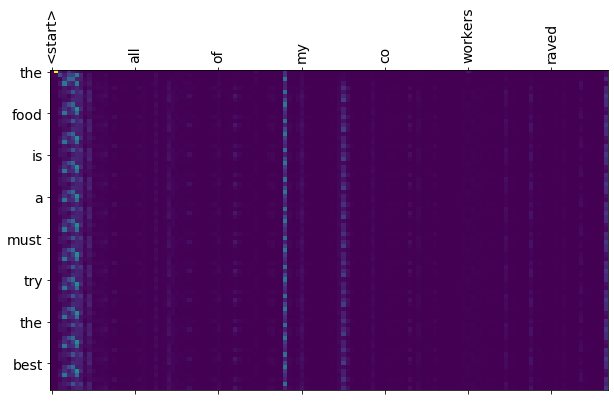

In [25]:
translate(u'All of my co-workers raved about this place and I finally had the opportunity to try it at lunch.  Wow, this was the most amazing burrito I have ever had.  For me, the flavor was out of this world.  There are other chain restaurants that make burritos that should shudder.  This place rocks.  I have only been two times and am entirely hooked.  the green pork burrito is my favorite so far.  <newline><newline>One piece of advice, if you plan on stopping in for your lunch break (12 p.m.), I would order in advance to save you time in line and waiting for your order.  Seating is all outside, Beach House says it all.', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)